# This is an Updated version of my previous public kernel <https://www.kaggle.com/kushal1506/moa-pytorch-0-01859-rankgauss-pca-nn>

**train_targets_nonscored.csv本身就是额外的训练数据（与要预测的特征无关，仅是为了帮助提升模型性能），本notebook没有用额外数据，且最小，所以先看这一个？**

## Updates -

* Implementing Feature Engineering 
* Implementing Label Smoothing

# 0 导入库与读取数据

In [1]:
import sys
'''

sys.path.append('../input/iterativestratification')
'''
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,FactorAnalysis

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import QuantileTransformer

In [4]:
'''
os.listdir('../input/lish-moa')
'''

"\nos.listdir('../input/lish-moa')\n"

In [5]:
'''
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')
'''
base_path = 'E:\AAAMyCodes\myjupyter\kaggle\Mechanisms of Action (MoA) Prediction\data'
train_features = pd.read_csv(base_path+'/train_features.csv')
train_targets_scored = pd.read_csv(base_path+'/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv(base_path+'/train_targets_nonscored.csv')

test_features = pd.read_csv(base_path+'/test_features.csv')
sample_submission = pd.read_csv(base_path+'/sample_submission.csv')

# 1 数据预处理

## 1.1 数据观察

In [6]:
# 由数据描述，很自然分离出GENES与CELLS两大类特征，注意这里返回的是list类型
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

**观察原始数据**

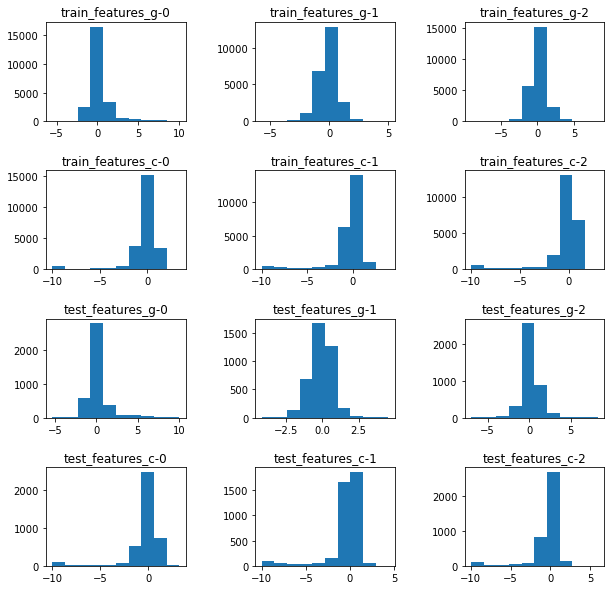

In [7]:
plot_example_list = ['g-0', 'g-1', 'g-2', 'c-0', 'c-1', 'c-2']
plt.figure(figsize=(10,10))
for i, plot_example in enumerate(plot_example_list):
    plt.subplot(4,3,(i+1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title('train_features_'+plot_example)
    plt.hist(train_features[plot_example])

    plt.subplot(4,3,(i+1+6))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title('test_features_'+plot_example)
    plt.hist(test_features[plot_example])

## 1.2 将前四个特征之外的特征转换为正态分布（train、test分别转换为正态分布）

In [8]:
#RankGauss
# str的list相加其实就是拼接
# 这里面有些操作应该有更简洁的写法，但是这种属于同一种功能的不同写法，就不改了，浪费时间，大致理解其意思即可
for col in (GENES + CELLS):

    transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
    # 设置train_features
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1) # 可是train_features[col].values本身就是这个形状啊
    transformer.fit(raw_vec)

    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    # 设置test_features
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

**观察QuantileTransformer转换后的数据分布**

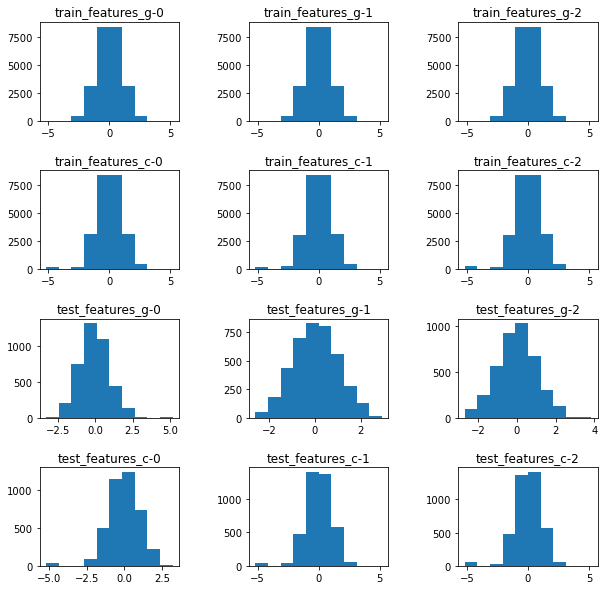

In [9]:
plot_example_list = ['g-0', 'g-1', 'g-2', 'c-0', 'c-1', 'c-2']
plt.figure(figsize=(10,10))
for i, plot_example in enumerate(plot_example_list):
    plt.subplot(4,3,(i+1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title('train_features_'+plot_example)
    plt.hist(train_features[plot_example])

    plt.subplot(4,3,(i+1+6))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title('test_features_'+plot_example)
    plt.hist(test_features[plot_example])

**统一设置所有用到的随机数**

In [10]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

## 1.3 对genes与cells特征进行pca降维

In [11]:
print('genes维数',train_features[GENES].shape)
print('cells维数',train_features[CELLS].shape)
# 可以看出有772列

genes维数 (23814, 772)
cells维数 (23814, 100)


GENES因子分析

In [12]:
# GENES
# 因子分析
n_comp = 90  #<--Update # 因子分析的因子数（降低为90列）

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])]) # 纵向拼接（仅是为了统一处理列，后面又分开）
data2 = (FactorAnalysis(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

# 为新获得的dataframe添加列名
train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# 将pca后的特征与原特征横向拼接
# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

cells因子分析

In [13]:
#CELLS
n_comp = 50  #<--Update

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (FactorAnalysis(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [14]:
print('降维并拼接原特征后的特征维数',train_features.shape)

降维并拼接原特征后的特征维数 (23814, 1016)


## 1.4 将前四个特征之外的特征转换为正态分布（train、test拼接转换为正态分布）

In [15]:
from sklearn.feature_selection import VarianceThreshold


#var_thresh = VarianceThreshold(0.8)  #<-- Update
var_thresh = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")

data = train_features.append(test_features) # 纵向拼接
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:]) # 仅处理第四列之外的特征

# 将处理过之后的数据拆分
train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]


# 重组train_features
train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)

# 重组test_features
test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

train_features.shape


(23814, 1016)

**观察处理之后的数据**

In [16]:
# plot_example_list = ['g-0', 'g-1', 'g-2', 'c-0', 'c-1', 'c-2']
# plt.figure(figsize=(10,10))
# for i, plot_example in enumerate(plot_example_list):
#     plt.subplot(4,3,(i+1))
#     plt.subplots_adjust(wspace=0.5, hspace=0.5)
#     plt.title('train_features_'+plot_example)
#     plt.hist(train_features[plot_example])
#
#     plt.subplot(4,3,(i+1+6))
#     plt.subplots_adjust(wspace=0.5, hspace=0.5)
#     plt.title('test_features_'+plot_example)
#     plt.hist(test_features[plot_example])

## 1.5 根据gene与cell特征对样本进行聚类
**注意这里将train与test一同用于KMeans的fit（为了保证聚类标准的一致性？）**

**dataframe添加KMeans聚类结果**

In [17]:
from sklearn.cluster import KMeans
def fe_cluster(train, test, n_clusters_g = 45, n_clusters_c = 15, SEED = 123):

    # 返回的是int值列表
    features_g = list(train.columns[4:776]) #4:776这个要自己观察dataframe数据去找
    features_c = list(train.columns[776:876])
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        # features是int列表，包含了要进行聚类的gene/cell的列索引
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data) # 这里为什么要将train与test的数据一同fit？（为了保证类别划分的标准一致？）
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]] # 添加一个新列，这个列标记了样本按gene/cell进行的分类结果
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}']) # 将类别节点（原来为[0, n_clusters)的整数）转换为哑结点(1,0,0,0……0这种形式)
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c) #  注意运行create_cluster是对train与test添加新列，并不会覆盖老数据，所以这种写法没关系
    return train, test

train_features ,test_features=fe_cluster(train_features,test_features)

## 1.6 dataframe添加新的数据特征的列，删除无用的行

In [18]:
def fe_stats(train, test):
    
    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])
    
    for df in train, test:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1) # 峰度
        df['g_skew'] = df[features_g].skew(axis = 1) # 偏斜度

        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)

        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
    return train, test

train_features,test_features=fe_stats(train_features,test_features)

**删除'cp_type'=='ctl_vehicle'的行，并重置索引以使得索引连续化**
因为这样的行没有moa，也就是对分类没有帮助，所以要删除

In [19]:
# merge 函数通过一个或多个键将数据集的行连接起来。
# 场景：针对同一个主键存在的两张包含不同特征的表，通过主键的链接，将两张表进行合并。合并之后，两张表的行数不增加，列数是两张表的列数之和。
train = train_features.merge(train_targets_scored, on='sig_id') # 这个拼接的目的是一同丢弃cp_type'=='ctl_vehicle的行（出于代码书写简洁考虑）
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True) # drop=True为重新添加连续索引之后，将老索引删除
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_scored.columns] # 一同丢弃相应行后，再分离出target（注意这里的train中仍然包含着target）

In [20]:
# cp_type现在没用了，删除
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

In [21]:
train

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,24,D1,1.147013,0.901837,-0.418317,-0.961328,-0.254748,-1.021168,-1.368753,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,72,D1,0.128837,0.676615,0.274303,0.090277,1.208714,0.688985,0.316750,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,48,D1,0.790059,0.940310,1.427325,-0.121422,-0.001534,1.494980,0.238795,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,48,D1,-0.729887,-0.277122,-0.441238,0.766535,2.327042,-0.862822,-2.304780,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,72,D2,-0.444200,-0.481230,0.974570,0.977613,1.468226,-0.874366,-0.372617,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,72,D1,0.247854,-1.231353,0.221655,-0.354349,-0.332003,0.570609,-0.150057,...,0,0,0,0,0,0,0,0,0,0
21944,id_fffb1ceed,24,D2,0.217631,-0.026850,-0.237436,-0.787443,-0.677697,0.919339,0.743390,...,0,0,0,0,0,0,0,0,0,0
21945,id_fffb70c0c,24,D2,-1.911045,0.581948,-0.588666,1.303231,-1.008858,0.851933,-0.302789,...,0,0,0,0,0,0,0,0,0,0
21946,id_fffcb9e7c,24,D1,0.826571,0.411264,0.433236,0.307423,1.075457,-0.024437,0.051466,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# 获得target的各列名
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

In [23]:
folds = train.copy()

# MultilabelStratifiedKFold是用于多标签分层的K折交叉验证
mskf = MultilabelStratifiedKFold(n_splits=5)

# 不清楚为啥非要用类型转换
# v_idx返回的是第f+1次k折交叉验证的验证集索引
# 至于这个x其实对函数计算并没有帮助，只不过根据官网介绍sklearn的非分层抽样要x，分层抽样算法上不用x，但为了兼容，还是要了x，本库为了与sklearn兼容，也要x了
for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[v_idx, 'kfold'] = int(f) # 添加一个新的列来记录下第f+1轮的验证集索引（与此对应的，第f+1轮，该列数值不是f的样本，即是训练集样本）

folds['kfold'] = folds['kfold'].astype(int)
folds

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,kfold
0,id_000644bb2,24,D1,1.147013,0.901837,-0.418317,-0.961328,-0.254748,-1.021168,-1.368753,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,72,D1,0.128837,0.676615,0.274303,0.090277,1.208714,0.688985,0.316750,...,0,0,0,0,0,0,0,0,0,2
2,id_000a6266a,48,D1,0.790059,0.940310,1.427325,-0.121422,-0.001534,1.494980,0.238795,...,0,0,0,0,0,0,0,0,0,1
3,id_0015fd391,48,D1,-0.729887,-0.277122,-0.441238,0.766535,2.327042,-0.862822,-2.304780,...,0,0,0,0,0,0,0,0,0,2
4,id_001626bd3,72,D2,-0.444200,-0.481230,0.974570,0.977613,1.468226,-0.874366,-0.372617,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,72,D1,0.247854,-1.231353,0.221655,-0.354349,-0.332003,0.570609,-0.150057,...,0,0,0,0,0,0,0,0,0,0
21944,id_fffb1ceed,24,D2,0.217631,-0.026850,-0.237436,-0.787443,-0.677697,0.919339,0.743390,...,0,0,0,0,0,0,0,0,0,4
21945,id_fffb70c0c,24,D2,-1.911045,0.581948,-0.588666,1.303231,-1.008858,0.851933,-0.302789,...,0,0,0,0,0,0,0,0,0,0
21946,id_fffcb9e7c,24,D1,0.826571,0.411264,0.433236,0.307423,1.075457,-0.024437,0.051466,...,0,0,0,0,0,0,0,0,0,1


In [24]:
print(train.shape)
print(folds.shape)
print(test.shape)
print(target.shape)
print(sample_submission.shape)

(21948, 1296)
(21948, 1297)
(3624, 1090)
(21948, 207)
(3982, 207)


**保存关键数据，方便py文件中调试**

In [ ]:
def my_save_data(data, data_name):
    # 储存数据为txt文件到当前文件夹中
    pd.DataFrame(data).to_csv(os.getcwd()+'//'+data_name+'.txt', index=False)

# 保存folds为csv文件
data_name_list = ['folds', 'target_cols', 'test', 'target', 'train']
for i, data in enumerate([folds, target_cols, test, target, train]):
    my_save_data(data=data, data_name=data_name_list[i])

# temp=pd.read_csv('folds.txt') # 从txt文件读取datframe类型数据的写法
# temp=pd.read_csv('target_cols.txt').values.T[0].tolist() # 从txt文件读取list类型数据的写法

In [26]:
import utils
data_name_list = ['folds', 'target_cols', 'test', 'target', 'train']
for i, data in enumerate([folds, target_cols, test, target, train]):
    utils.save_data(data=data, file_name=data_name_list[i])


# 2 Dataset Classes

In [25]:
# pytorch自定义数据结构类至少含有以下三个函数
class MoADataset:
    # 定义MoADataset数据结构
    # torch.utils.data.DataLoader类中需要dataset数据结构
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct
    

In [26]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
#         print(inputs.shape)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds



In [27]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    # @语法装饰器，相当于_smooth = staticmethod(_smooth)
    # @staticmethod是一类特殊的用法，静态方法_smooth属于 SmoothBCEwLogits class,但是 Pizza类和实例都可以调用该方法：
    # SmoothBCEwLogits._smooth is SmoothBCEwLogits()._smooth
    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        # 断言可以在条件不满足程序运行的情况下直接返回错误, assert expression 等价于：
        # if not expression:
        #     raise AssertionError
        assert 0 <= smoothing < 1
        # Python 中的 with 语句用于异常处理，封装了 try…except…finally 编码范式，提高了易用性
        # torch.no_grad()为上下文管理器， 就是在一个类里，实现了__enter__和__exit__的方法，这个类的实例就是一个上下文管理器。
        # 在torch.no_grad()上下文管理器中，禁止使用梯度计算
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [28]:
class Model(nn.Module):      # <-- Update
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.25)
        self.dense2 = nn.Linear(hidden_size, hidden_size)
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.25)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [29]:
# 将'cp_time', 'cp_dose'列转换为哑结点（得到的数据，将原来的列删除，将后来得到的列放到最后）
def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

In [30]:
feature_cols = [c for c in process_data(folds).columns if c not in target_cols] # 提取非目标列
feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]  # 将费目标列中的这两列删去
len(feature_cols)

1092

In [33]:
target_cols

['5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist',
 'acetylcholinesterase_inhibitor',
 'adenosine_receptor_agonist',
 'adenosine_receptor_antagonist',
 'adenylyl_cyclase_activator',
 'adrenergic_receptor_agonist',
 'adrenergic_receptor_antagonist',
 'akt_inhibitor',
 'aldehyde_dehydrogenase_inhibitor',
 'alk_inhibitor',
 'ampk_activator',
 'analgesic',
 'androgen_receptor_agonist',
 'androgen_receptor_antagonist',
 'anesthetic_-_local',
 'angiogenesis_inhibitor',
 'angiotensin_receptor_antagonist',
 'anti-inflammatory',
 'antiarrhythmic',
 'antibiotic',
 'anticonvulsant',
 'antifungal',
 'antihistamine',
 'antimalarial',
 'antioxidant',
 'antiprotozoal',
 'antiviral',
 'apoptosis_stimulant',
 'aromatase_inhibitor',
 'atm_kinase_inhibitor',
 'atp-sensitive_potassium_channel_antagonist',
 'atp_synthase_inhibitor',
 'atpase_inhibitor',
 'atr_kinase_inhibitor',
 'aurora_kinase_inhibitor',
 '

In [50]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 5            #<-- Update
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size=2048


In [51]:
def run_training(fold, seed):
    
    seed_everything(seed)

    # 将'cp_time', 'cp_dose'列转换为哑结点（得到的数据，将原来的列删除，将后来得到的列放到最后）
    train = process_data(folds)
    test_ = process_data(test)

    # 根据kfold列，获得训练集与验证集索引
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index

    # 根据索引训练集验证集索引获得相应dataframe数据，并重置索引
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)

    # 划分出训练集与验证集的特征与目标
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values

    # 通过特征与目标，实例化自定义dataset类
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)

    # 利用自定义dataset类，实例化DataLoader类
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.to(DEVICE)

    # 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=WEIGHT_DECAY)
    # tortch.optim.lr_scheduler.OneCycleLR类，一种学习率策略
    # The 1cycle policy anneals the learning rate from an initial learning rate to some maximum learning rate and then from that maximum learning rate to some minimum learning rate much lower than the initial learning rate.
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    
    loss_tr = SmoothBCEwLogits(smoothing =0.001)
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_tr, trainloader, DEVICE)
        print(f"SEED: {seed}, FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"SEED: {seed} ,FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,

    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions


In [52]:
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))

    # 注意这个NFOLDS和之前MultilabelStratifiedKFold的轮次相同（前面run_training函数也有体现）
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [30]:
# Averaging on multiple SEEDS

SEED = [940, 1513, 1269,1392,1119,1303]  #<-- Update
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

# 多次运行求平均值
for seed in SEED:
    
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED) # 其实和最后都加起来再除一样（除法结合律）
    predictions += predictions_ / len(SEED)

train[target_cols] = oof
test[target_cols] = predictions


SEED: 940, FOLD: 0, EPOCH: 0, train_loss: 0.4709183501241648
SEED: 940 ,FOLD: 0, EPOCH: 0, valid_loss: 0.02435992184494223
SEED: 940, FOLD: 0, EPOCH: 1, train_loss: 0.02370495936306922
SEED: 940 ,FOLD: 0, EPOCH: 1, valid_loss: 0.018982262590101787
SEED: 940, FOLD: 0, EPOCH: 2, train_loss: 0.022423562053860962
SEED: 940 ,FOLD: 0, EPOCH: 2, valid_loss: 0.19759794239486966
SEED: 940, FOLD: 0, EPOCH: 3, train_loss: 0.02696398992523335
SEED: 940 ,FOLD: 0, EPOCH: 3, valid_loss: 0.0197769112352814
SEED: 940, FOLD: 0, EPOCH: 4, train_loss: 0.02219309817081776
SEED: 940 ,FOLD: 0, EPOCH: 4, valid_loss: 0.018827627652457782
SEED: 940, FOLD: 0, EPOCH: 5, train_loss: 0.02147800004298704
SEED: 940 ,FOLD: 0, EPOCH: 5, valid_loss: 0.017931388478193963
SEED: 940, FOLD: 0, EPOCH: 6, train_loss: 0.021078649692345356
SEED: 940 ,FOLD: 0, EPOCH: 6, valid_loss: 0.017856099749250072
SEED: 940, FOLD: 0, EPOCH: 7, train_loss: 0.02083339995664099
SEED: 940 ,FOLD: 0, EPOCH: 7, valid_loss: 0.01763602096055235
SEED

In [31]:
train_targets_scored

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
len(target_cols)


206

In [33]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)


y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / target.shape[1]
    
print("CV log_loss: ", score)
    

CV log_loss:  0.01454439906674656


In [34]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)

In [35]:
sub.shape

(3982, 207)